# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [4]:
import tarfile
import os
import numpy as np

import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import math
import skimage.color


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

# **** type = test, train, validation ****
type = "test"

# Load images
file_ = open(os.path.join(data_base_path, data_folder, type + ".txt"), "r")
im_names = []
name_i = file_.readline()
im_names.append(name_i[0:(len(name_i)-1)])
while (name_i):
    name_i = file_.readline()
    if name_i :
        if name_i[len(name_i)-1] == '\n':
            im_names.append(name_i[0:(len(name_i)-1)])
        else:
            im_names.append(name_i)

filenames = [os.path.join(data_base_path, data_folder,"images", type, name) + '.jpg' for name in im_names]
test = skimage.io.imread_collection(filenames)
print('Number of images: ', len(test))


Number of images:  50


In [3]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

annotations_xmls = [parse_file(os.path.join(data_base_path, data_folder,"annotations", type, name) + '.xml') for name in im_names]

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [4]:
from skimage.measure import label, regionprops
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from skimage.morphology import disk, square


# Function that rescales the intensity value and sets it between 0 and 255
def rescale_intensity(image):
    y_im, x_im, z_im = image.shape
    out = image.copy()
    for i in range(0,z_im):
        image2 = image[:,:,i]
        minimum = np.min(image2)
        maximum = np.max(image2)
        out[:,:,i]=(image2 - minimum)/(maximum-minimum)*255
    return out

# Function that, using K-Means, finds the centers of each element in the image that is not part of the background.
# Furthermore, each element is labelled
def treshold_varroa(image):
    out = image[:,:,0].copy()
    image = rescale_intensity(image)
    y_im, x_im, z_im = image.shape
    X_r = np.reshape(image[:,:,0], (x_im*y_im))
    X_g = np.reshape(image[:,:,1], (x_im*y_im))
    X_b = np.reshape(image[:,:,2], (x_im*y_im))

    X = np.array([X_r, X_g, X_b])
    X = np.transpose(X)

    #plt.scatter(X[:, 0], X[:, 2], s=1);

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)

    #plt.scatter(X[:, 0], X[:, 2], c=y_kmeans, s=1, cmap='viridis')

    centers = kmeans.cluster_centers_
    #plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

    y_kmeans = np.reshape(y_kmeans, (y_im,x_im))
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    label_ = centers[:,0].argmin()
    for x in range(0,x_im):
        for y in range(0,y_im):
            if y_kmeans[y,x]==label_ :
                out[y,x]=0
            else:
                out[y,x]=255
    return out

def treshold_varroa2(image, threshold_val):
    y_im, x_im, z_im = image.shape
    out = image[:,:,2].copy()
    for x in range(0,x_im):
        for y in range(0,y_im):
            if image[y,x,2] > threshold_val:
                out[y,x] = 255
            else:
                out[y,x] = 0
    return out
                

def inverse_image(image):
    # This function only works for thresholded images and it inverses the blak pixels with the white pixels and vice versa.
    # It is usefull when we use morphological operations because they work on the logical ones and not on the zeros.
    out = image.copy()
    y_image, x_image = image.shape
    for x in range(0,x_image):
        for y in range(0,y_image):
            if image[y,x]==0:
                out[y,x]=255
            else:
                out[y,x]=0
    return out

# Function that creates a histogram which counts the varroas in each image
def create_histogram(image, xmin, ymin, xmax, ymax):
    # This function looks in a rectangle from xmin to xmax, from ymin to ymax how many different labels are present and it
    # create a histogram
    max_label = np.max(image)
    count_label_j = np.zeros(max_label-1)
    for x in range(xmin,xmax+1):
        for y in range(ymin,ymax+1):
            for j in range(0,max_label-1):
                # j+2 because the array starts at zero and the label at 1, and the lable 1 corresponds to the background and we don't want it 
                if image[y,x] == j+2 :
                    count_label_j[j] = count_label_j[j] + 1
    return count_label_j

def extract_varroa(image_lab, label_varroa):
    # This function extracts the varroa having the label "label_varroa" on the image "i"
    # The output is a thresholded image with the varroa's pixels in black, the function also returns the number 
    # of pixels of this varroa
    image = image_lab.copy()
    y_image, x_image = image.shape
    for x in range(0,x_image):
        # This is an inversed threshold, because the morphological operations are working on the true values
        for y in range(0,y_image):
            if image_lab[y,x] == label_varroa:
                image[y,x] = 255
            else:
                image[y,x] = 0
    # We applie a dilation because previously we applied an erosion in order to separate the superposed varroas
    # and now we would like to obtain the entire varroa
    image = skimage.morphology.dilation(image,disk(int(varona_size*0.85)))
    
    # After the morphological operation we reverse the image
    image = inverse_image(image)
    
    
    x_min = x_image
    x_max = 0
    y_min = y_image
    y_max = 0
    for x in range(0,x_image):
        for y in range(0,y_image):
            if image[y,x]==0:
                if x < x_min:
                    x_min = x
                if x > x_max:
                    x_max = x
                if y < y_min:
                    y_min = y
                if y > y_max:
                    y_max = y
    h = y_max-y_min
    w = x_max-x_min
    
    return x_min, y_min, w, h

little_hole = 1
varona_size = 12

In [5]:
def detect_by_segmentation(img, index):
    # the index is used only in order to plot the image with the rectangles
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    img = rescale_intensity(img)
    img[:,:,2] = skimage.filters.median(img[:,:,2], square(3))
    threshold_val = 35
    image_thr = treshold_varroa2(img, threshold_val).copy()
    
    # We inverse the image because the morphological operations work only on the true elements and not with
    # the false
    image = inverse_image(image_thr)
    
    # We close the little holes present in the varroas
    image = skimage.morphology.closing(image,square(little_hole))
    
    # We open with a circle a bit bigger than the varroa size and we subtract it from the original image
    # with this apprach we eliminate the parts bigger than a varroa
    image = image - skimage.morphology.opening(image,disk(int(varona_size*1.7)))
    
    # We open with a circle a bit smaller than the size of the varroa, like this all the parts smaller than a varroa are deleted
    image_morph = skimage.morphology.opening(image,disk(varona_size))
    
    # In order to label correctly the varroas they don't have to be superposed and we do an erosion with
    # a circle smaller than the size of the varroa
    image = skimage.morphology.erosion(image_morph,disk(int(varona_size*0.85)))
    
    image = inverse_image(image)
    image_thresholded2 = image.copy()
    image_thresholded2 = image.astype(int)*255
    
    # Display results
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 6),
                                        sharex=True, sharey=True)

    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('original image after median filter', fontsize=12)

    ax2.imshow(image_thr, cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title('thresholded image', fontsize=12)
    
    ax3.imshow(inverse_image(image_morph), cmap=plt.cm.gray)
    ax3.axis('off')
    ax3.set_title('thresholded image after morphological operations', fontsize=12)
    
    annotations = annotations_xmls[index]
    
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax3.add_patch(rect)
    
    fig.tight_layout()

    plt.show()
    
    
    
    image_labeled = skimage.measure.label(image_thresholded2, connectivity=2, background=255)

    nbr_varroas = np.max(image_labeled) - 1
    print("the number of detected varroas is ", nbr_varroas)
    
    # for label_varroa from 2 to nbr_varroas+1
    if nbr_varroas > 1:
        a = np.array([extract_varroa(image_labeled, 2)])
        for label_varroa in range(3,nbr_varroas+2):
            b = np.array([extract_varroa(image_labeled, label_varroa)])
            a = np.append(a,b, axis=0)
    else:
        a = []
    return a

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

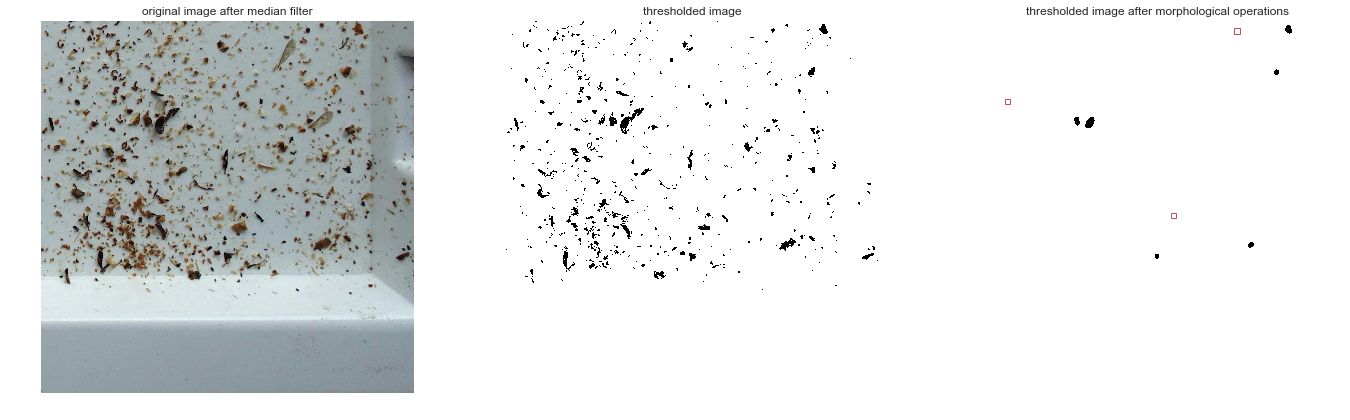

the number of detected varroas is  6


In [6]:
index = 5
a = detect_by_segmentation(test[index], index)

In [15]:
test[index][1:3,1,:]

array([[128, 136, 139],
       [129, 137, 140]], dtype=uint8)

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [5]:
# function that extracts the pixels that are between two thresholds and sets them to white, whereas the 
# others will be set to black
def threshold_band(image, threshold1, threshold2,rgb):
    thresholded_image = image.copy()
    y_image, x_image = image.shape[0:2]
    
    for i in range(0,x_image):
        for j in range(0,y_image):
            if image[j,i,rgb] < threshold1:
                thresholded_image[j,i] = 255
            elif image[j,i,rgb] > threshold2:
                thresholded_image[j,i] = 255
            else:
                thresholded_image[j,i] = 0
    return thresholded_image

# Function that takes two values in a vector form and transforms them into a complex number
# This function is used later to get the complex notation of the Fourier descriptors
def from2d_to_complex(vector):
    vector_complex = []
    N = len(vector)
    for n in range(0,N):
        vector_complex.append(complex(vector[n][0],vector[n][1]))
    return vector_complex
    

In [16]:
import numpy as np
#import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

index = 5
zeros_contour = []
ones_contour = []
nbr_im = 1 
x_im, y_im = test[index][0:2]
for i in range(0,nbr_im):
    s = np.linspace(0, 2*np.pi, 70)
    x = 14 + 13*np.cos(s)
    y = 14 + 13*np.sin(s)
    init = np.array([x, y]).T
    
    img0 = threshold_band(zeros_im[i,:,:], 0, 80)
    contour0 = active_contour(img0, init, alpha=1, beta=1, gamma=1)
    zeros_contour.append(contour0)
                           
    img1 = threshold_band(ones_im[i,:,:], 0, 80)
    contour1 = active_contour(img1, init, alpha=1, beta=10, gamma=1)
    ones_contour.append(contour1)

zeros_contour_complex = []
ones_contour_complex = []
nbr_im, y_im, x_im = zeros_im.shape
for i in range(0,nbr_im):
    zeros_contour_complex.append(from2d_to_complex(zeros_contour[i]))
    ones_contour_complex.append(from2d_to_complex(ones_contour[i]))



NameError: name 'zeros_im' is not defined

In [13]:
# Make fourier transformation of the contour
index = 5
nbr_im = 1
x_im, y_im = test[index][0:2]
nbr_features = 4
X = np.zeros((2*nbr_im, nbr_features))
for i in range(0,nbr_im):
    temp0 = np.fft.fft(zeros_contour_complex[i])
    temp1 = np.fft.fft(ones_contour_complex[i])
    # here we take the modulus of the firsts two harmonics of the DFT
    # We do not take the zero harmonic because it represents the shift of the contour, its position 
    # on the space image, like this it is shift independent
    # To make the operation rotation indipendent we decide to use only the modulus of the DFT,
    # because any rotation of the contour will only affect the phase
    
    # X is the vector that has to be classified using K-means, each row rappresents an image, 
    # each column a featurs, the two featurs used are the first two harmonics
    for j in range(0, nbr_features):
        X[i,j] = abs(temp0[j+1])
        X[nbr_im+i,j] = abs(temp1[j+1])

NameError: name 'zeros_contour_complex' is not defined

In [11]:
x_im

array([[[  5,   5,   5],
        [  5,   5,   5],
        [  5,   5,   5],
        ...,
        [  3,   7,  10],
        [  3,   7,  10],
        [  2,   6,   9]],

       [[  5,   5,   5],
        [  5,   5,   5],
        [  5,   5,   5],
        ...,
        [  4,   8,  11],
        [  3,   7,  10],
        [  3,   7,  10]],

       [[  6,   6,   6],
        [  6,   6,   6],
        [  6,   6,   6],
        ...,
        [  4,   8,  11],
        [  4,   8,  11],
        [  4,   8,  11]],

       ...,

       [[156, 160, 161],
        [156, 160, 161],
        [155, 159, 160],
        ...,
        [  9,  11,   8],
        [  8,  13,   9],
        [  8,  13,   9]],

       [[157, 161, 162],
        [157, 161, 162],
        [156, 160, 161],
        ...,
        [  8,  10,   7],
        [  7,  12,   8],
        [  8,  13,   9]],

       [[158, 162, 163],
        [157, 161, 162],
        [156, 160, 161],
        ...,
        [  8,  10,   7],
        [  6,  11,   7],
        [  7,  12,   8]]

In [39]:
import time
import math
def detect_by_Fourier(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code
    #pseudo code
    # 1. get image size
    # 2. decide how much to slide the window at each time
    # 3. slide it and detect varroas
    
    # 1. get image size
    img_x, img_y = img.shape[0:2]
    
    # 2. decide how much to slide the window at each time
    '''
    # let's suppose we want to slide a window 10 times along x and y 
    # -> size of the window: 
    window_factor = 10
    win_x = (img_x/window_factor)
    win_y = (img_y/window_factor)
    '''
    #Let's suppose that the size of the window is constant at 50x50
    win_size = 50
    
    # 3. slide the window
    x_len = len(np.arange(0,img_x,math.ceil(img_x/win_size)))
    y_len = len(np.arange(0,img_y,math.ceil(img_y/win_size)))
    for i in range(x_len):
        for j in range(y_len):
            #One window on the image
            window = img[(win_size*i):(win_size*(i+1)), (win_size*j):(win_size*(j+1)), :]

            #Function that uses Fourier descriptors
            

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code